In [1]:
import json
import pandas as pd
all_results = {}
fname = "model_results.json"
with open(fname,'r') as file:
    try:
        all_results = json.load(file)
    except json.JSONDecodeError as e:
        all_results = {}
        
df = pd.DataFrame(all_results).T
# df
df = pd.concat([df.drop(['test_scores'], axis=1), pd.json_normalize(df['test_scores']).set_index(df.index)], axis=1)
if 'gen_label' in df.columns:
    df['gen_augment'] = df.gen_label.str.contains('dcgan')
else:
    df['gen_augment'] = False
df.tail()

,n_train,n_test,n_val,train_scores,val_scores,n_normal,n_pneumo,gen_label,Accuracy,Precision,Recall,F1 Score,TP,TN,FP,FN,gen_augment
2024-01-18 15:27:38.587179,252,5576,28,"{'Accuracy': 0.575, 'Precision': 1.0, 'Recall'...","{'Accuracy': 0.4375, 'Precision': 1.0, 'Recall...",126,126,No gen just 280 train images,0.819684,0.969892,0.312977,0.473242,451,4113,14,990,False
2024-01-18 15:33:38.010483,532,5576,28,"{'Accuracy': 0.9450757575757576, 'Precision': ...","{'Accuracy': 0.9375, 'Precision': 0.9, 'Recall...",126,126,280 train images and 280 dcgan images 10001 ep...,0.919181,0.775125,0.968772,0.861197,1396,3722,405,45,True
2024-01-18 16:31:47.934311,90,5756,10,"{'Accuracy': 0.5, 'Precision': 0, 'Recall': 0....","{'Accuracy': 0.5, 'Precision': 0, 'Recall': 0....",45,45,No gen just 100 train images,0.733217,0.000000,0.000000,0.000000,0,4216,1,1533,False
2024-01-18 16:36:08.747108,44,5806,6,"{'Accuracy': 0.5, 'Precision': 0, 'Recall': 0....","{'Accuracy': 0.6666666666666666, 'Precision': ...",22,22,No gen just 50 train images,0.732851,0.888889,0.005138,0.010217,8,4244,1,1549,False
2024-01-18 16:45:09.508933,44,5806,6,"{'Accuracy': 0.47619047619047616, 'Precision':...","{'Accuracy': 0.5, 'Precision': 0, 'Recall': 0....",22,22,No gen just 50 train images,0.731644,0.500000,0.000642,0.001283,1,4244,1,1556,False


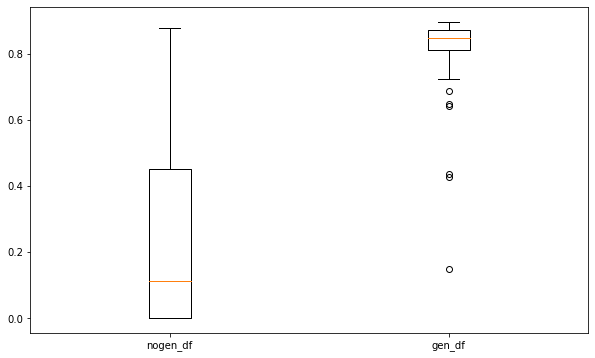

In [2]:
gen_df = df[(~df.gen_label.isna()) & (df.gen_label.str.contains('dcgan')) & (df.gen_label.str.contains('10001'))]['F1 Score']
nogen_df = df[(~df.gen_label.isna()) & (df.gen_label.str.contains('No gen'))]['F1 Score']
nogen_df.mean(), gen_df.mean()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([nogen_df, gen_df], labels=['nogen_df', 'gen_df'])
plt.show()

In [3]:
df2 = df[~df.gen_label.isna()][['gen_label','F1 Score']]
df2['gen_augment'] = df2.gen_label.str.contains('dcgan')
df2['original_train'] = pd.to_numeric(df2.gen_label.str.extract('(\d+) train')[0], errors='coerce')
df2['n_augment'] = pd.to_numeric(df2.gen_label.str.extract('(\d+) dcgan images')[0], errors='coerce') # .astype(int)
df2.original_train.value_counts()

200    71
100     7
260     6
160     6
240     6
230     6
220     6
210     6
190     6
180     6
170     6
150     6
270     6
140     6
130     6
120     6
110     6
280     6
250     6
300     4
290     4
50      2
Name: original_train, dtype: int64

In [4]:
df2[df2.gen_augment==False].original_train.value_counts()
df2['F1 Score'].mean()

0.5237474156253764

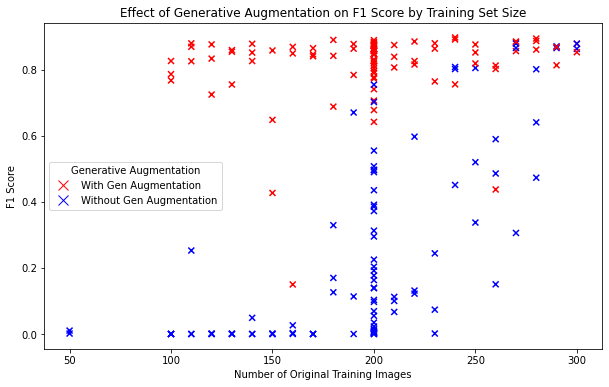

In [5]:
# ax = df2.plot.scatter(x='original_train', y='F1 Score', style='.', figsize=(12, 6), c=df['original_train'], cmap='viridis')
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(
    df2.original_train, 
    df2['F1 Score'], 
    c=df2['gen_augment'].map({True: 'r', False: 'b'}), 
    marker='x')
# plt.set_cmap('plasma_r')
ax.set_title('Effect of Generative Augmentation on F1 Score by Training Set Size')
ax.set_ylabel('F1 Score')
ax.set_xlabel('Number of Original Training Images')
legend_labels = {'With Gen Augmentation': 'r', 'Without Gen Augmentation': 'b'}
handles = [plt.Line2D([0], [0], marker='x', color=color, linestyle='', markersize=10, label=label)
           for label, color in legend_labels.items()]
ax.legend(handles=handles, title='Generative Augmentation')
ax.legend(handles=handles, title='Generative Augmentation')
plt.show()

In [6]:
df2.shape

(190, 5)

<Figure size 1080x432 with 0 Axes>

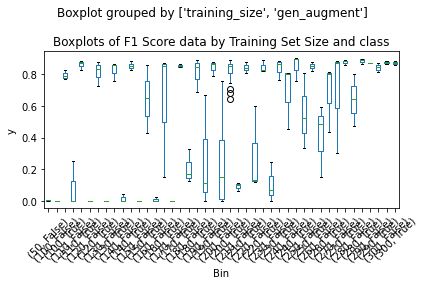

In [7]:
bin_size = 10
df2['training_size'] = (df2.original_train // bin_size) * bin_size
plt.figure(figsize=(15, 6))
# df2.boxplot(column='F1 Score', by=['gen_augment','training_size_bin'], grid=False)
df2.boxplot(column='F1 Score', by=['training_size', 'gen_augment'], grid=False)
plt.title('Boxplots of F1 Score data by Training Set Size and class')
plt.xlabel('Bin')
plt.ylabel('y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# df2

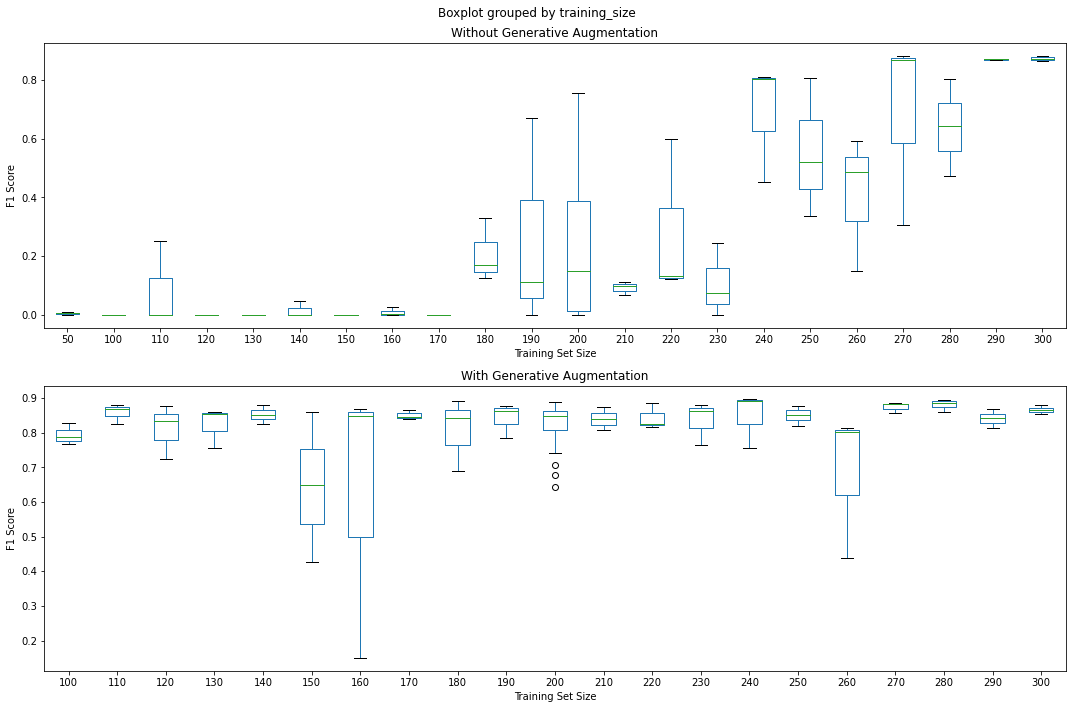

In [8]:
df_2bps = df2#[df2['training_size']>40]
gen_df = df_2bps[df_2bps.gen_augment == True]
no_gen_df = df_2bps[df_2bps.gen_augment == False]
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

no_gen_df.boxplot(column='F1 Score', by='training_size', ax=axs[0], grid=False)
axs[0].set_title('Without Generative Augmentation')
axs[0].set_xlabel('Training Set Size')
axs[0].set_ylabel('F1 Score')

gen_df.boxplot(column='F1 Score', by='training_size', ax=axs[1], grid=False)
axs[1].set_title('With Generative Augmentation')
axs[1].set_xlabel('Training Set Size')
axs[1].set_ylabel('F1 Score')
plt.tight_layout()
plt.show()

In [9]:
# df2[df2.training_size==70]#.groupby(['training_size']).count()

In [10]:
df2[df2.original_train==200].gen_augment.value_counts() # 36 False, 35 True

False    36
True     35
Name: gen_augment, dtype: int64

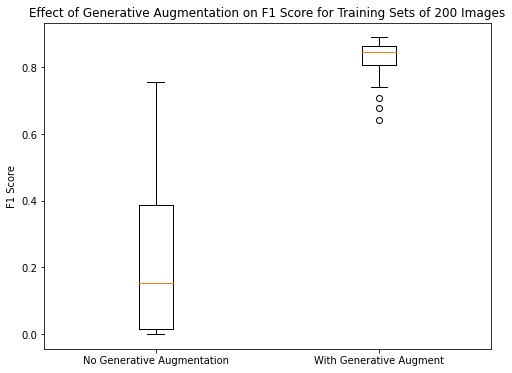

In [22]:
df3 = df2[df2.original_train==200]
fig, ax = plt.subplots(figsize=(8, 6))
no_gen = df3[df3.gen_augment==False]['F1 Score']
yes_gen = df3[df3.gen_augment==True]['F1 Score']
ax.boxplot([no_gen, yes_gen], labels=['No Generative Augmentation', 'With Generative Augment'])
ax.set_title('Effect of Generative Augmentation on F1 Score for Training Sets of 200 Images')
ax.set_ylabel('F1 Score')
plt.show()

In [12]:
df2.reset_index().sort_values(by='index').head(20)

,index,gen_label,F1 Score,gen_augment,original_train,n_augment,training_size
0,2024-01-09 19:23:33.719771,No gen just 200 train images,0.002695,False,200,NaN,200
1,2024-01-09 19:29:57.039968,No gen just 200 train images,0.555342,False,200,NaN,200
2,2024-01-10 15:44:45.452889,200 train images and 200 dcgan images,0.706901,True,200,200.0,200
3,2024-01-10 16:25:29.128362,No gen just 200 train images,0.312887,False,200,NaN,200
4,2024-01-10 16:30:35.004101,200 train images and 200 dcgan images 5001 epochs,0.678249,True,200,200.0,200
5,2024-01-11 18:39:01.032509,No gen just 200 train images,0.006716,False,200,NaN,200
6,2024-01-11 18:42:24.661745,200 train images and 200 dcgan images 10001 ep...,0.857935,True,200,200.0,200
7,2024-01-14 16:17:10.510768,No gen just 200 train images,0.191981,False,200,NaN,200
8,2024-01-14 16:20:35.317211,200 train images and 200 dcgan images 10001 ep...,0.831407,True,200,200.0,200
9,2024-01-15 15:51:47.197931,No gen just 200 train images,0.000000,False,200,NaN,200


In [13]:
no_gen.mean()

0.21879079808420518

In [14]:
df2['n_augment'] = pd.to_numeric(df2.gen_label.str.extract('(\d+) dcgan images')[0], errors='coerce')
df4 = df2[~df2.n_augment.isna()]
(df4.original_train - df4.n_augment).value_counts()

0.0    93
dtype: int64

<Figure size 1080x432 with 0 Axes>

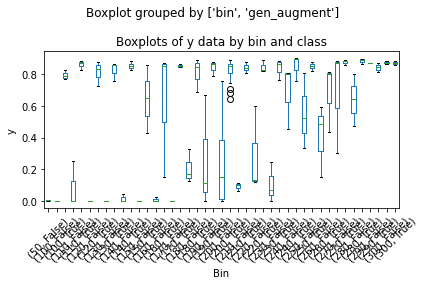

In [15]:
bin_size = 10
df2['bin'] = (df2.original_train // bin_size) * bin_size
plt.figure(figsize=(15, 6))
df2.boxplot(column='F1 Score', by=['bin', 'gen_augment'], grid=False)
plt.title('Boxplots of y data by bin and class')
plt.xlabel('Bin')
plt.ylabel('y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# df2

<AxesSubplot:title={'center':'Number of Datapoints by Training Set Size'}, xlabel='Training Set Size', ylabel='Number of Datapoints'>

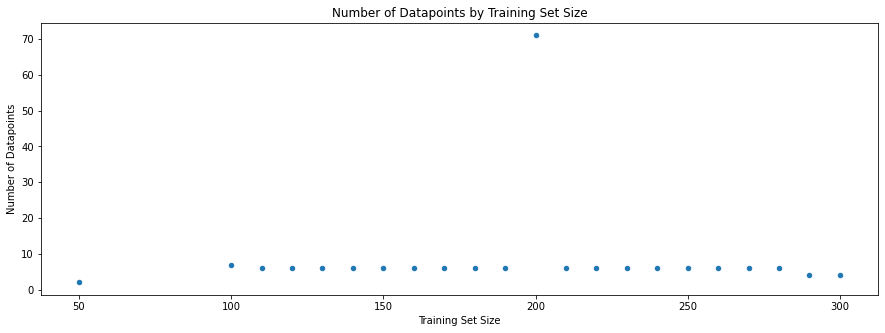

In [16]:
# Number of datapoints for each training size
df3 = df2[df2['training_size']>40]
pd.DataFrame(df3.sort_values(by='bin')['bin'].value_counts()).reset_index().plot.scatter(
    x='index', y='bin', xlabel='Training Set Size', ylabel='Number of Datapoints', title='Number of Datapoints by Training Set Size', figsize=(15,5))

In [17]:
pd.DataFrame(df3.groupby(['bin','gen_augment']).count()['F1 Score']).reset_index().sort_values(by='F1 Score')

,bin,gen_augment,F1 Score
0,50,False,2
40,290,True,2
39,290,False,2
41,300,False,2
42,300,True,2
5,120,False,3
25,220,False,3
26,220,True,3
27,230,False,3
28,230,True,3


<AxesSubplot:xlabel='n_augment', ylabel='Number of Datapoints'>

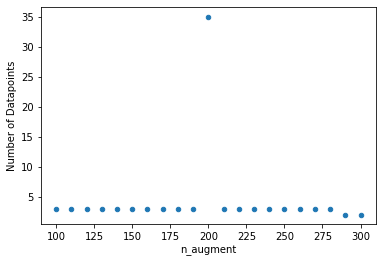

In [18]:
# Number of datapoints for each n_generated
df4 = df2#[df2['training_size']>40]
df4 = df4[df4['gen_augment']==True]
pd.DataFrame(df4.sort_values(by='n_augment')['n_augment'].value_counts()).reset_index().plot.scatter(x='index',y='n_augment', xlabel='n_augment', ylabel='Number of Datapoints')

Text(0.5, 0, 'Number of Original Training Images')

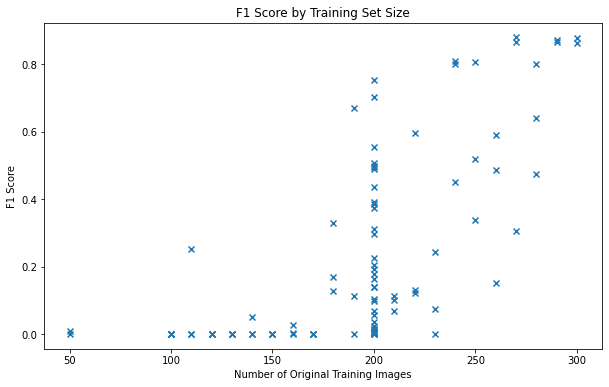

In [19]:
df_nogen = df2[df2.gen_augment==False]
df_nogen = df_nogen[df_nogen.original_train > 49]
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(
    df_nogen.original_train, 
    df_nogen['F1 Score'], 
    marker='x')
# plt.set_cmap('plasma_r')
ax.set_title('F1 Score by Training Set Size')
ax.set_ylabel('F1 Score')
ax.set_xlabel('Number of Original Training Images')

<AxesSubplot:xlabel='Training Set Size', ylabel='Number of Datapoints'>

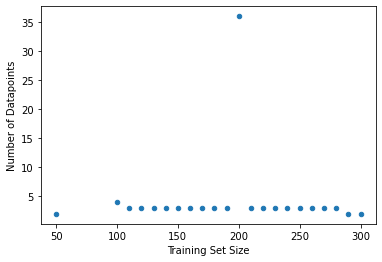

In [20]:
# Number of datapoints for each training size
# df3 = df2#[df2['training_size']>40]
pd.DataFrame(df_nogen.sort_values(by='bin')['bin'].value_counts()).reset_index().plot.scatter(x='index',y='bin', xlabel='Training Set Size', ylabel='Number of Datapoints')

In [21]:
df = df[~df.gen_label.isna()][['gen_label','F1 Score','Accuracy','n_generated']]
df['original_train'] = pd.to_numeric(df.gen_label.str.extract('(\d+) train')[0], errors='coerce')
df = df.sort_values(by=['original_train','n_generated'])
df['Uses Gen'] = df.gen_label.str.contains('dcgan')
df.tail()

KeyError: "['n_generated'] not in index"

In [ ]:
df_usesgen = df[df['Uses Gen']==True].sort_values(by='n_generated')
df_usesgen = df_usesgen[df_usesgen['n_generated'] < 50]
# ax = df[df['original_train']==40].plot.scatter(x='n_generated', y='F1 Score', style='.', figsize=(12, 6))
ax = df_usesgen[df_usesgen['original_train']==40].boxplot(column='F1 Score', by=['n_generated'], grid=False, figsize=(10,6))
# plt.colorbar(ax.collections[0], label='Original Train')
plt.title("F1 Score by Number of Generated Images with 40 Original Training Images")
plt.xlabel("Number of Images Generated")
plt.ylabel("F1 Score")
plt.show()

In [ ]:
pd.DataFrame(df_usesgen[df_usesgen['original_train']==40].groupby(['original_train','n_generated'])['F1 Score'].count())

In [ ]:
df = df.sort_values(by='original_train')

# Mapping colors based on 'Uses Gen' column
mp = df['Uses Gen'].map({True: 'b', False: 'r'})

# Creating the scatter plot
ax = df.plot.scatter(x='n_generated', y='F1 Score', style='.', c=mp, figsize=(12, 6))

# Creating a custom legend
legend_labels = {'b': 'Uses Gen True', 'r': 'Uses Gen False'}
handles = [plt.Line2D([0], [0], marker='.', color=color, label=label, linestyle='None') for color, label in legend_labels.items()]

# Adding the legend to the plot
ax.legend(handles=handles, title='Uses Gen', loc='upper left')

# Show the plot
plt.show()